# Image Histograms

Goal of the lecture:

1. Load the RGB region from the previous lectures
2. Convert the data from the original `uint16` type to the `uint8` range
3. Calculate the histogram of each individual band
4. Apply a "Modified Contrast Adjustment"
5. Apply histogram equalization
6. Generate a mask image and visualize overlayed image


## Data loading

Short recap:
- In the previous lecture we downloaded an S2 tile.
- The data values themselves were not touched!
    - That means that the data-type is `uint16`.
    - The selected region had no `NO_DATA` values (these are encoded with the value `0`)
        - No need to apply masking

In [1]:
# some code from that last labs

# Provided template to download file; not relevant for course
import requests
from tqdm.rich import tqdm
from pathlib import Path


def download_file_with_progress(url: str, output_file: Path):
    """
    Given a `url` as a String and an `output_file` as a file-path the item will
    be downloaded and written to the `output_file`. If the `output_file` already
    exists, it will be overwritten.
    """
    s = requests.Session()
    chunk_size = 2**20  # mb
    with s.get(url, stream=True) as resp:
        with open(output_file, "wb") as f:
            print(f"Saving to {output_file}")
            for data in tqdm(
                resp.iter_content(chunk_size=chunk_size), 
                total=int(resp.headers.get("content-length", 0)) // chunk_size, 
                unit="MB",
                unit_scale=True,
                desc="Downloading...",
            ):
                f.write(data)

In [2]:
data_path = Path("./data")
data_path.mkdir(exist_ok=True)
# For quick prototyping there is no such things as _too many_ asserts!
assert data_path.exists, "Should exist after calling mkdir!"

In [3]:
tile_name = Path("S2A_MSIL2A_20240308T100841_N0510_R022_T33UUU_20240308T143352")
output_filepath = data_path / tile_name.with_suffix(".SAFE.zip")
output_filepath

PosixPath('data/S2A_MSIL2A_20240308T100841_N0510_R022_T33UUU_20240308T143352.SAFE.zip')

In [4]:
# re-hosted file on TUB-Cloud for fast download during class ~1GB before and 1GB after unpacking
sentinel_tile_url = "https://tubcloud.tu-berlin.de/s/2EMnZwypF2pK5XG/download/S2A_MSIL2A_20240308T100841_N0510_R022_T33UUU_20240308T143352.SAFE.zip"

if not output_filepath.exists():
    download_file_with_progress(sentinel_tile_url, output_filepath)

Output()

Saving to data/S2A_MSIL2A_20240308T100841_N0510_R022_T33UUU_20240308T143352.SAFE.zip


/tmp/ipykernel_815/935986111.py:20: TqdmExperimentalWarning: rich is experimental/alpha
  for data in tqdm(


In [5]:
import zipfile

zipf = zipfile.ZipFile(output_filepath)
zipf.extractall(path="data")
unzipped_dir = Path(data_path / tile_name.with_suffix(".SAFE"))
assert unzipped_dir.exists(), f"{unzipped_dir} does not exist!"

In [6]:
import geopandas
import numpy as np
import rasterio

def read_s2_jp2_data_with_clipping(
    band_data_path: Path, clip_geoseries: geopandas.GeoSeries, envelope: bool = True
) -> np.ndarray:
    """
    Given the `band_data_path` to a JP2000 encoded GeoTIFF file, return those parts that are overlapping with the
    `clip_geoseries` GeoSeries. By default, the bounding box (`envelope`) of the geometry will be used to define the
    region of interest.
    """
    # open the GeoTIFF file which also contains the CRS metadata
    with rasterio.open(band_data_path) as data:
        # ensure that the data is using the same coordinate reference system and reproject if they don't
        reprojected_geoseries = clip_geoseries.to_crs(data.crs)
        # use the bounding box if `envelope` is set => Make sure that the matrix we get back can contain
        # only valid values
        reprojected_geoseries = (
            reprojected_geoseries.envelope if envelope else reprojected_geoseries
        )
        # Use crop to only return the matrix that contains our region of interest
        # Use `all_touched=True` to make sure that the border is also conisdered "inside" the region of interest
        out_img, _out_transform = rasterio.mask.mask(
            data, reprojected_geoseries, crop=True, all_touched=True
        )
        # drop singleton axes
        out_img = out_img.squeeze()
    return out_img

class S2TileReader:
    def __init__(self, directory: Path):
        """
        Initialize the reader with a directory containing the SAFE file of a Sentinel-2 product.

        Parameters
        ----------
        directory : Path
            The directory containing the SAFE file of a Sentinel-2 product.
        """
        assert directory.is_dir(), f"{directory} is not a directory"
        self.image_files = list(directory.glob(f"**/IMG_DATA/*.jp2"))
        if len(self.image_files) == 0:
            self.image_files = list(directory.glob(f"**/IMG_DATA/R60m/*.jp2"))
            self.image_files.extend(list(directory.glob(f"**/IMG_DATA/R20m/*.jp2")))
            self.image_files.extend(list(directory.glob(f"**/IMG_DATA/R10m/*.jp2")))
        self.band2file_mapping = self._bands()
        self.bands = sorted(self.band2file_mapping.keys())
        print(f"{len(self.band2file_mapping)} images found in {directory}")

    def _bands(self):
        """
        Extract the band names from the image files and create a mapping from band name to file path.

        Example:
        {
            "B01": Path("path/to/B01.jp2"),
            "B02": Path("path/to/B02.jp2"),
            ...
        }
        or if the product has multiple resolutions:
        {
            "B01_60m": Path("path/to/R60m/B01.jp2"),
            "B02_10m": Path("path/to/R10m/B02.jp2"),
            ...
        }
        """
        return {"_".join(x.stem.split("_")[2:]):x for x in self.image_files}

    def read_band(self, band: str):
        """
        Read the data of a specific band. The data is returned as a numpy array. If the band is a single channel,
        the array will have shape (height, width). If the band is a multi-channel band, the array will have shape
        (height, width, channels).

        Parameters
        ----------
        band : str
            The name of the band to read. Must be one of the bands in the product.
            Use the `bands` attribute to see the available bands.
        """
        assert band in self.bands, f"Band {band} invalid. Please select one of {self.bands}"
        img_path = self.band2file_mapping[band]
        with rasterio.open(self.band2file_mapping[band]) as f:
            data = f.read()
        if data.shape[0] == 1:
            return data.squeeze(0)
        elif data.shape[0] == 3:
            return np.transpose(data, (1, 2, 0))

    def read_band_data_with_clipping(
        self, band: str, clip_geoseries: geopandas.GeoSeries, envelope: bool = True
    ) -> np.ndarray:
        assert band in self.bands, f"Band {band} invalid. Please select one of {self.bands}"
        img_path = self.band2file_mapping[band]
        return read_s2_jp2_data_with_clipping(img_path, clip_geoseries, envelope=envelope)


s2_reader = S2TileReader(unzipped_dir)
rgb_arr_full = np.stack(
    [s2_reader.read_band(b) for b in ("B04_10m", "B03_10m", "B02_10m")],
    axis=-1,
)
rgb_arr_full.shape

36 images found in data/S2A_MSIL2A_20240308T100841_N0510_R022_T33UUU_20240308T143352.SAFE


(10980, 10980, 3)

In [27]:
rgb_arr = rgb_arr_full[-600:, -600:]
# What is the shape?
rgb_arr

array([[[1539, 1681, 1402],
        [1531, 1642, 1361],
        [1549, 1664, 1396],
        ...,
        [2080, 1857, 1556],
        [2096, 1885, 1574],
        [2188, 1914, 1622]],

       [[1547, 1658, 1407],
        [1536, 1646, 1382],
        [1556, 1632, 1370],
        ...,
        [2252, 1933, 1645],
        [2150, 1884, 1606],
        [2180, 1876, 1616]],

       [[1560, 1640, 1402],
        [1532, 1645, 1383],
        [1531, 1629, 1383],
        ...,
        [2340, 2048, 1772],
        [2238, 2052, 1715],
        [2034, 1886, 1584]],

       ...,

       [[2016, 1960, 1616],
        [1978, 1947, 1570],
        [1940, 1890, 1575],
        ...,
        [1231, 1302, 1151],
        [1416, 1426, 1240],
        [1505, 1492, 1297]],

       [[1926, 1875, 1576],
        [1900, 1875, 1542],
        [1919, 1894, 1554],
        ...,
        [1228, 1305, 1143],
        [1326, 1382, 1209],
        [1470, 1388, 1228]],

       [[1864, 1862, 1538],
        [1876, 1848, 1545],
        [1888, 1

In [9]:
assert rgb_arr_full[600:, 600: 3] # low right corner

/tmp/ipykernel_815/3009053592.py:1: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  assert rgb_arr_full[600:, 600: 3] # low right corner


AssertionError: 

In [10]:
assert not (rgb_arr == 0).any(), "There is an unexpected <NO_DATA> value!"
assert rgb_arr.dtype == np.uint16, "The data is not in the original format anymore!"

In [11]:
# let us store the rgb_arr for the next lab as a npz file!
np.savez(
    "data/rgb_arr",
    red=rgb_arr[:, :, 0],
    green=rgb_arr[:, :, 1],
    blue=rgb_arr[:, :, 2],
)

## Converting to `uint8`

For our following analysis we are would like the image to be in the `uint8` range [0, 255].
To re-scale the data we have several options.
We could apply a normalization strategy, like min-max-normalization or quantile normalization with rescaling, but we want to keep the data as close as possible to the _original_ data.

To accomplish the re-scaling to `uint8`, we convert the data to the _reflectance_ value, according to the Sentinel-2 documentation.
This will project the data to the range [0, 1]*.
The formulae has _"recently"_ (January 2022) changed to:

$$ 
\text{reflectance}_i = \frac{\text{DN}_i + \text{Offset}_i}{\text{QuantificationValue}_i}
$$

where:
- $\text{QuantificationValue}_i$ = `10_000` for Sentinel-2 data
    - Can be found in the `MTD_MSIL2A.xml` file under `BOA_QUANTIFICATION_VALUE`
- $\text{DN}_i$ is the digital number that is provided in the JPEG2000 files as a `uint16` value
- $\text{Offset}_i$ is the _newly_ introduced band-offset 
    - Can be found in the `MTD_MSIL2A.xml` file under `BOA_ADD_OFFSET`
    - Often the same value for a given tile (for our tile it is `-1_000`)

The details can be found on the [Copernicus Sentinel-2 product update page](https://scihub.copernicus.eu/news/News00931).
For a more general overview of the Sentinel-2 L2A data, see the [Sentinelhub sentinel-L2A documentation](https://docs.sentinel-hub.com/api/latest/data/sentinel-2-l2a/).


*) This is not entirely true; the reflectance value can become larger than 1. This is not important for our investigation and we will clamp the values to ensure that the range is actually [0, 1].

### The rabbit hole
As we have seen above, the Sentinel-2 data structure/format is not as easy to work with as other classic computer vision imagery.
For our course it is sufficient to know how to derive the reflectance values from the source data.
The details of the Sentinel-2 data format is a rabbit hole that is not relevant for the contents of the course.
The key point is that the data cannot be nicely visualized without any image processing techniques.

### Data Type Issues

When working with `uintX` beware of [under-/overflow](https://en.wikipedia.org/wiki/Integer_overflow)!
One _trick_ is to convert the source data into a different format.
This may be done explicitely by calling `np.int64`, for example, or by adding/substracting float values

In [12]:
A_uint = np.array([0], dtype=np.uint8)
A_uint - 1

array([255], dtype=uint8)

In [13]:
A_int = np.array([0], dtype=np.int64)
A_int - 1

array([-1])

In [14]:
np.int64(A_uint) - 1

array([-1])

In [15]:
A_uint - 1.0

array([-1.])

In [16]:
img_float = (np.int64(rgb_arr) - 1_000) / 10_000
img_float = np.clip(img_float, 0.0, 1.0)
img = np.uint8(img_float * 255) #img-floats are reflectance
img

array([[[13, 17, 10],
        [13, 16,  9],
        [13, 16, 10],
        ...,
        [27, 21, 14],
        [27, 22, 14],
        [30, 23, 15]],

       [[13, 16, 10],
        [13, 16,  9],
        [14, 16,  9],
        ...,
        [31, 23, 16],
        [29, 22, 15],
        [30, 22, 15]],

       [[14, 16, 10],
        [13, 16,  9],
        [13, 16,  9],
        ...,
        [34, 26, 19],
        [31, 26, 18],
        [26, 22, 14]],

       ...,

       [[25, 24, 15],
        [24, 24, 14],
        [23, 22, 14],
        ...,
        [ 5,  7,  3],
        [10, 10,  6],
        [12, 12,  7]],

       [[23, 22, 14],
        [22, 22, 13],
        [23, 22, 14],
        ...,
        [ 5,  7,  3],
        [ 8,  9,  5],
        [11,  9,  5]],

       [[22, 21, 13],
        [22, 21, 13],
        [22, 21, 13],
        ...,
        [ 5,  7,  4],
        [ 6,  8,  4],
        [ 8,  7,  4]]], dtype=uint8)

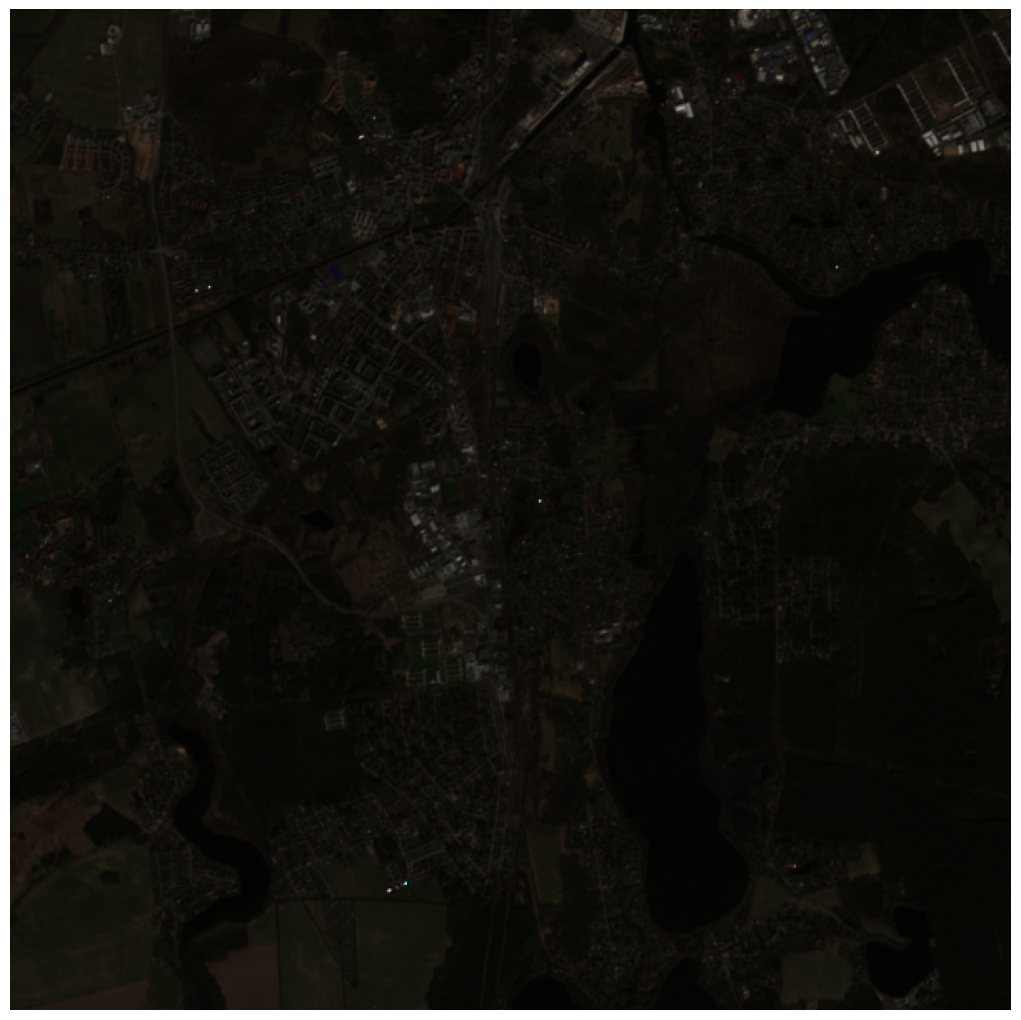

In [17]:
import matplotlib.pyplot as plt

# change default figure size
plt.rcParams["figure.figsize"] = (13, 13)


def imshow(*args, **kwargs):
    """Short wrapper that calls `plt.imshow` with the provided arguments, but turns of the axis"""
    plt.imshow(*args, **kwargs)
    plt.axis("off")


imshow(img)

## Calculating histograms

Question: What is the corect number of bins and the required `range` if we want to have a bin for each brightness value?

In [18]:
?np.histogram

Signature: np.histogram(a, bins=10, range=None, density=None, weights=None)
Docstring:
Compute the histogram of a dataset.

Parameters
----------
a : array_like
    Input data. The histogram is computed over the flattened array.
bins : int or sequence of scalars or str, optional
    If `bins` is an int, it defines the number of equal-width
    bins in the given range (10, by default). If `bins` is a
    sequence, it defines a monotonically increasing array of bin edges,
    including the rightmost edge, allowing for non-uniform bin widths.

    .. versionadded:: 1.11.0

    If `bins` is a string, it defines the method used to calculate the
    optimal bin width, as defined by `histogram_bin_edges`.

range : (float, float), optional
    The lower and upper range of the bins.  If not provided, range
    is simply ``(a.min(), a.max())``.  Values outside the range are
    ignored. The first element of the range must be less than or
    equal to the second. `range` affects the automatic bin

Answer:
- We have values from 0 -- 255.
- We want to count how often each individual value appears.
- So we have 256 buckets (one for each number)
- The left histogram edge is always inclusive
    - 255 should be left histogram edge of the last bin

257

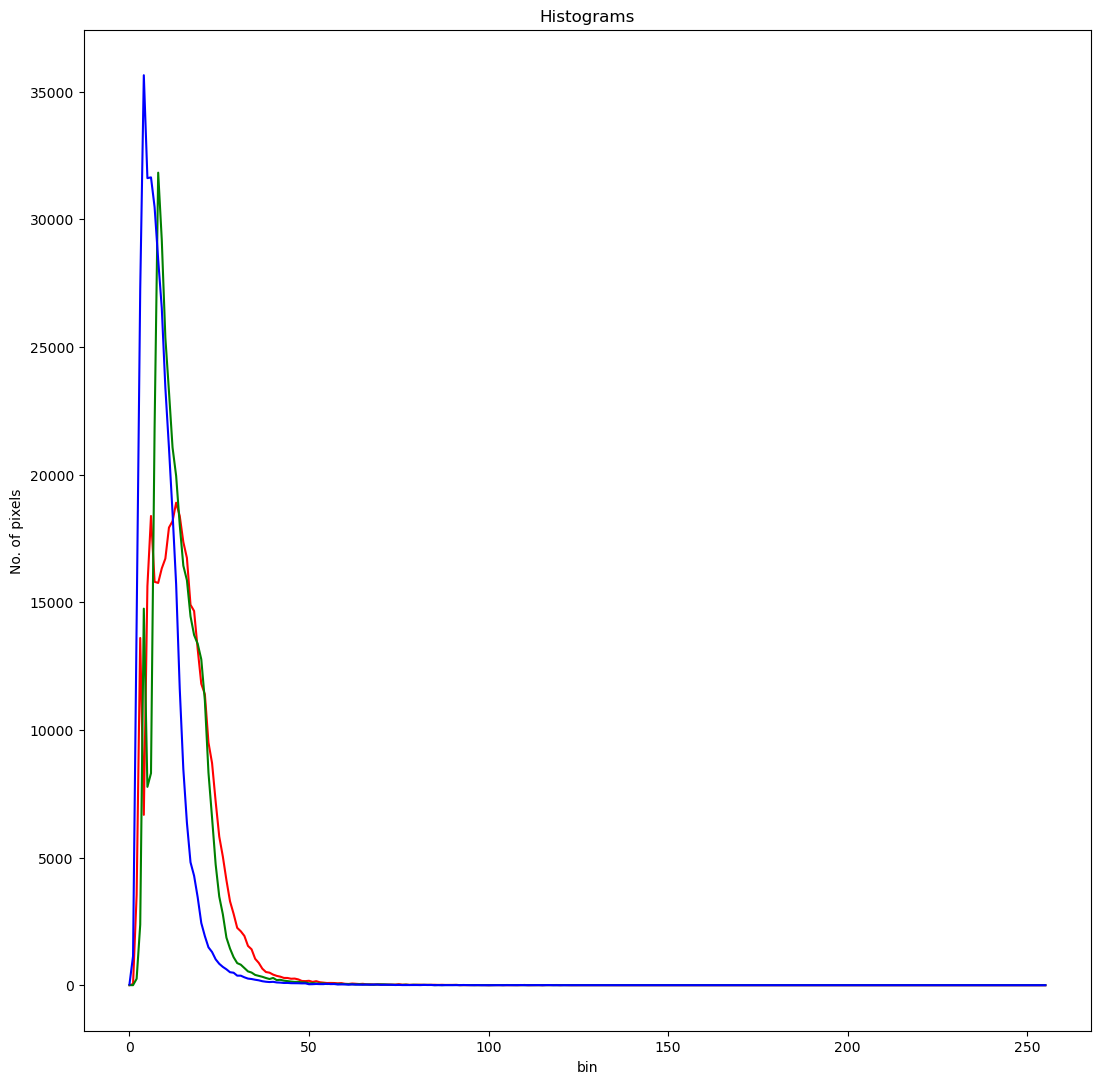

In [21]:
# print RGB histogram
channel_names = ["red", "green", "blue"]

for i, channel in enumerate(channel_names):
    hist, bin_edges = np.histogram(img[:, :, i], bins=256, range=[0, 256])
    assert bin_edges[0] == 0
    assert bin_edges[-2] == 255
    # 256 brightness values => 256 bins
    assert len(hist) == 256
    # using the fact that the channel names are also an accepted color name
    plt.plot(hist, color=channel)
    plt.xlabel("bin")
    plt.ylabel("No. of pixels")
    plt.title("Histograms")
len(bin_edges)

### Modified Contrast Adjustment

In the lecture we have defined:

$$
I_\text{out}[n, m] = \begin{cases}
    0, & \text{if}\ I_\text{in}[m, n] < I_\text{min}' \\
    (2^L - 1) \cdot \frac{I_\text{in}[m, n] - I_\text{min}'}{I_\text{max}' - I_\text{min}'}, & \text{if}\ I_\text{min}' \leq I[m, n] \leq I_\text{max}' \\
    2^L - 1, & \text{if}\ I_\text{in}[n, m] > I_\text{max}'
\end{cases}
$$

where:
- $I_\text{in}[n, m]$ is the input pixel value at the location $[n, m]$
- $I_\text{out}[n, m]$ is the output pixel value at the location $[n, m]$ after applying the modified contrast adjustment method
- $I_\text{min}'$ is the _selected_ minimum target value of the adjusted scale
    - This does _not_ has to be minimum value of the target input image $I$
- $I_\text{max}'$ is the _selected_ maximum target value of the adjusted scale
    - This does _not_ has to be maximum value of the target input image $I$
- $L$ is the number of bits for the discrete brightness values


In [28]:
# m_c: stretching
# implicitely convert by providing these values as float values
fmin = 2.0
fmax = 38.0

adj_img = 255 * ((img - fmin) / (fmax - fmin))
adj_img.min(), adj_img.max()

(-14.166666666666666, 1792.0833333333333)

In [29]:
adj_img = np.clip(adj_img, 0, 255)
# convert it back to uint8
adj_img = np.uint8(adj_img)
# imshow(adj_img)

In [30]:
adj1 = 255 * ((img - fmin) / (fmax - fmin))
adj1 = np.clip(adj_img, 0, 255)
adj1 = np.uint8(adj_img)

adj2 = np.clip(img, fmin, fmax)
adj2 = 255 * ((adj2 - fmin) / (fmax - fmin))
adj2 = np.uint8(adj2)

(adj1 - adj2).sum()

0

In [31]:
?np.clip

Signature: np.clip(a, a_min, a_max, out=None, **kwargs)
Docstring:
Clip (limit) the values in an array.

Given an interval, values outside the interval are clipped to
the interval edges.  For example, if an interval of ``[0, 1]``
is specified, values smaller than 0 become 0, and values larger
than 1 become 1.

Equivalent to but faster than ``np.minimum(a_max, np.maximum(a, a_min))``.

No check is performed to ensure ``a_min < a_max``.

Parameters
----------
a : array_like
    Array containing elements to clip.
a_min, a_max : array_like or None
    Minimum and maximum value. If ``None``, clipping is not performed on
    the corresponding edge. Only one of `a_min` and `a_max` may be
    ``None``. Both are broadcast against `a`.
out : ndarray, optional
    The results will be placed in this array. It may be the input
    array for in-place clipping.  `out` must be of the right shape
    to hold the output.  Its type is preserved.
**kwargs
    For other keyword-only arguments, see the
    

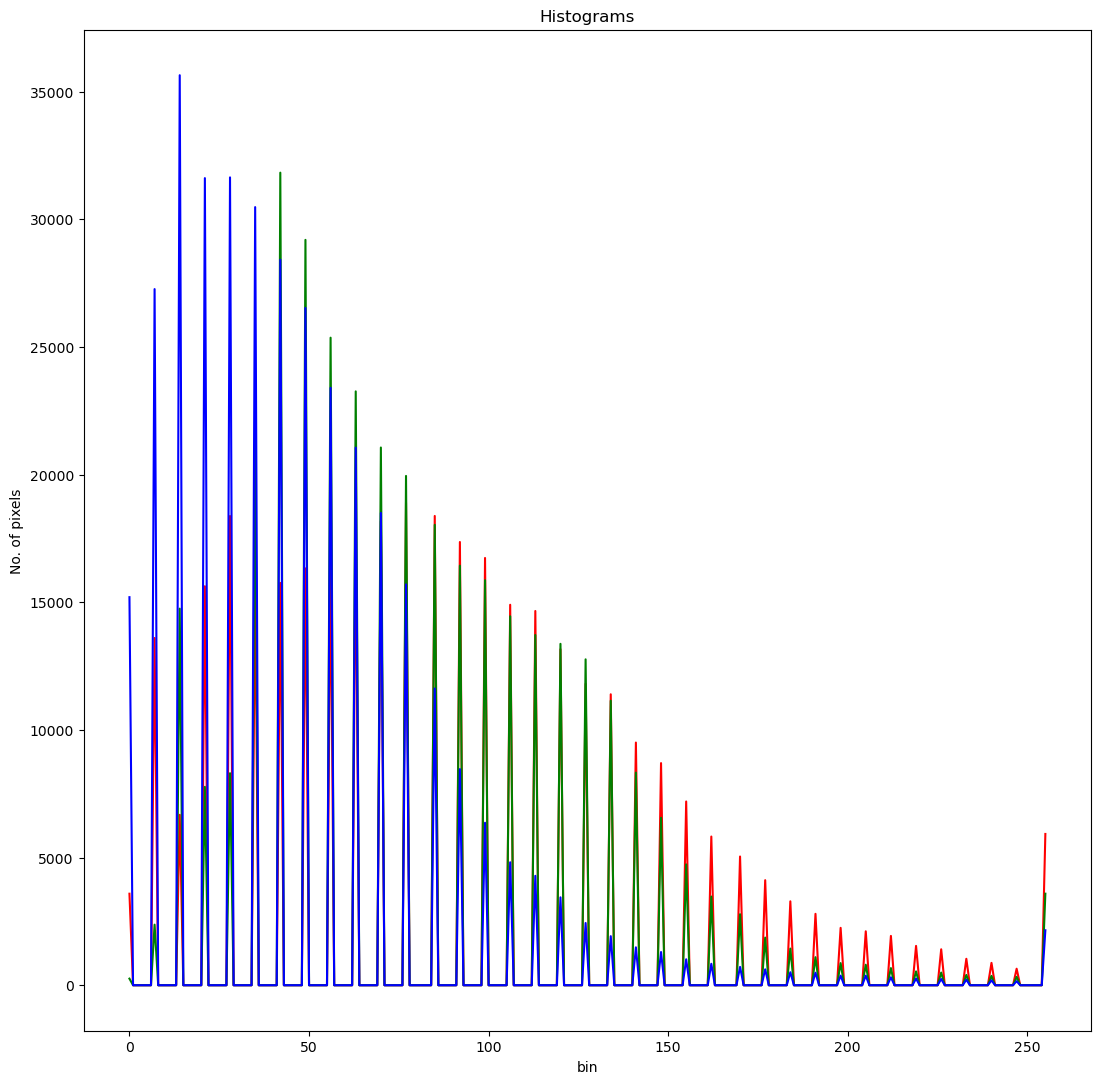

In [32]:
for i, channel in enumerate(channel_names):
    hist, bin_edges = np.histogram(adj_img[:, :, i], 256, range=[0, 256])
    # hist, bin_edges = np.histogram(img[:, :, i], bins=np.arange(257))
    assert bin_edges[0] == 0
    assert bin_edges[-2] == 255
    # 256 brightness values => 256 bins
    assert len(hist) == 256
    # using the fact that the channel names are also an accepted color name
    plt.plot(hist, color=channel)
    plt.xlabel("bin")
    plt.ylabel("No. of pixels")
    plt.title("Histograms")

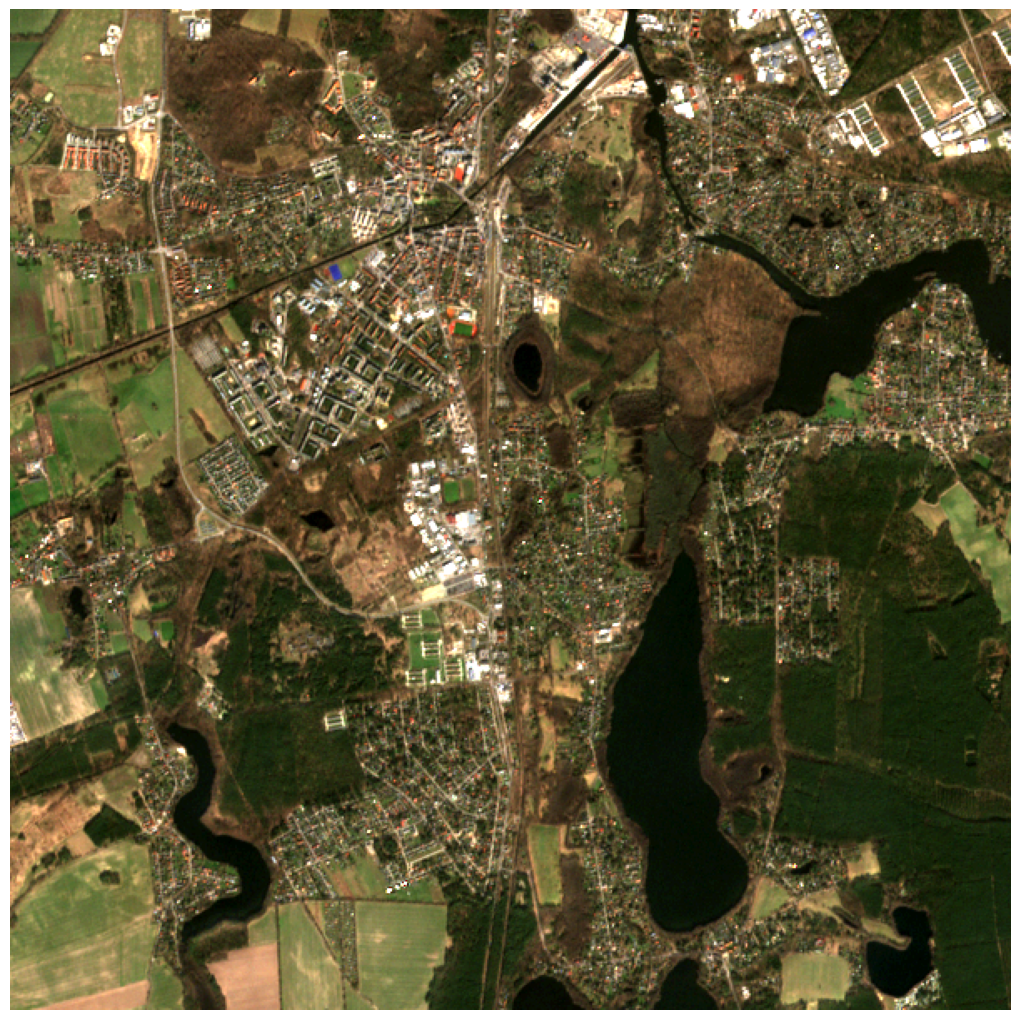

In [33]:
imshow(adj_img)

## Histogram Equalization

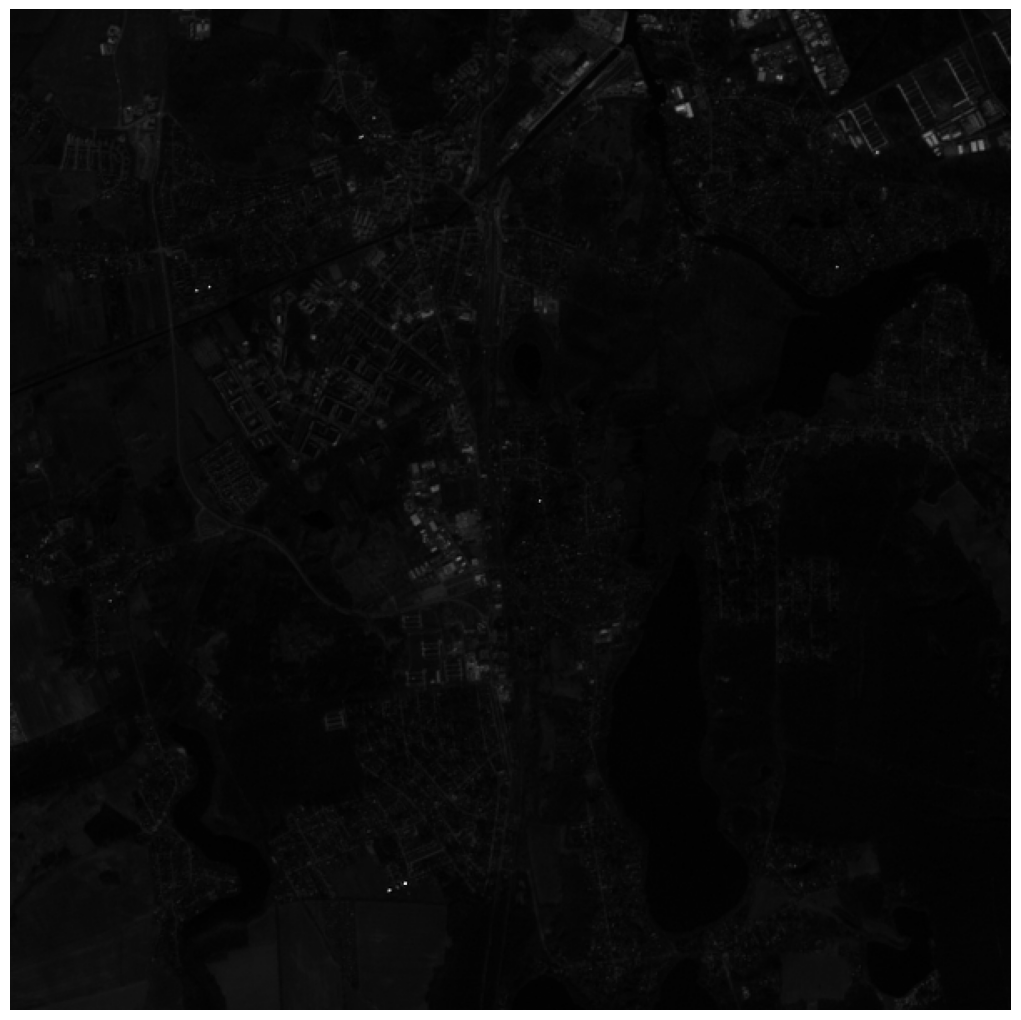

In [34]:
img_B = img[..., 2].copy()
# disable implicit min/max normalization!
imshow(img_B, cmap="gray", vmin=0, vmax=255)

### In-course practice:

- The formulae from the lecture originated from "Remote Sensing Digital Image Analysis -- An Introduction 2013" Ch. 4.4
    - Refer to this chapter for the full derivation of the formulae that is used here

$$ y' = \text{constant} \times C(x) = \frac{L' - 1}{N} \times C(x) = (L' - 1) \cdot C_\text{norm}(x)$$
where:
- $0 \text{--} (L' - 1)$ are the $L$ brightness values available in the image
    - These values do not _have_ to be present in the image
    - For 8-bit images the $L' = 256$
- $N$ is the total number of pixels in the image
- $C(x)$ is the cumulative histogram function (hint: it can be calculated as a cumulative sum)

The values $y'$ must then be converted to discrete integer values.
We use the recommended approach of rounding to the nearest integer value.

a ) plot the cumulative histogram. 

In [35]:
img_B

array([[10,  9, 10, ..., 14, 14, 15],
       [10,  9,  9, ..., 16, 15, 15],
       [10,  9,  9, ..., 19, 18, 14],
       ...,
       [15, 14, 14, ...,  3,  6,  7],
       [14, 13, 14, ...,  3,  5,  5],
       [13, 13, 13, ...,  4,  4,  4]], dtype=uint8)

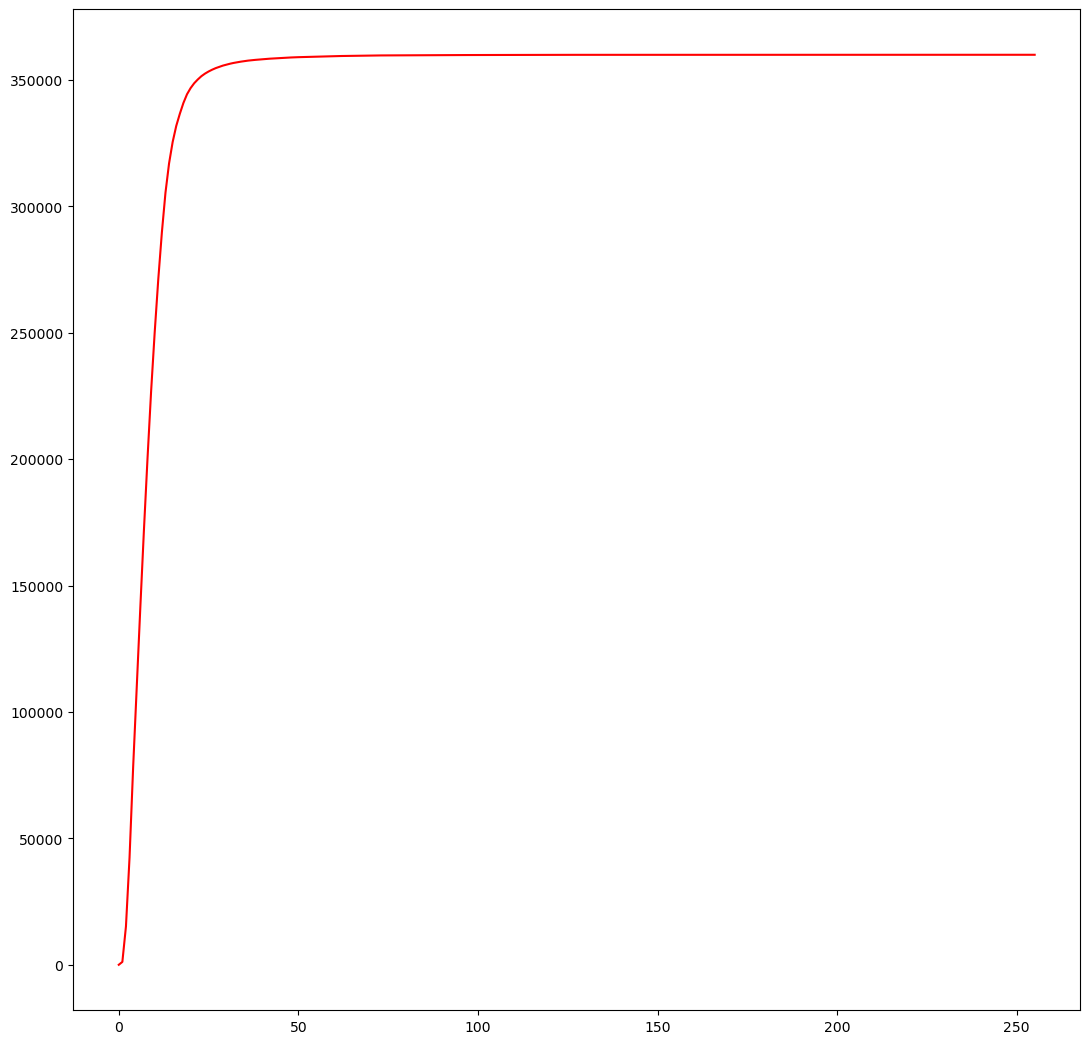

In [36]:
hist_B, hist_edges = np.histogram(img_B, 256, range=[0, 256])
assert hist_edges[0] == 0
assert hist_edges[-2] == 255
assert len(hist_B) == 256
cum_hist_B = hist_B.cumsum()
plt.figure(figsize=(5, 3))
plt.plot(cum_hist_B, color="r");

b) calculate the equalized histogram 
<!-- START REMOVAL -->

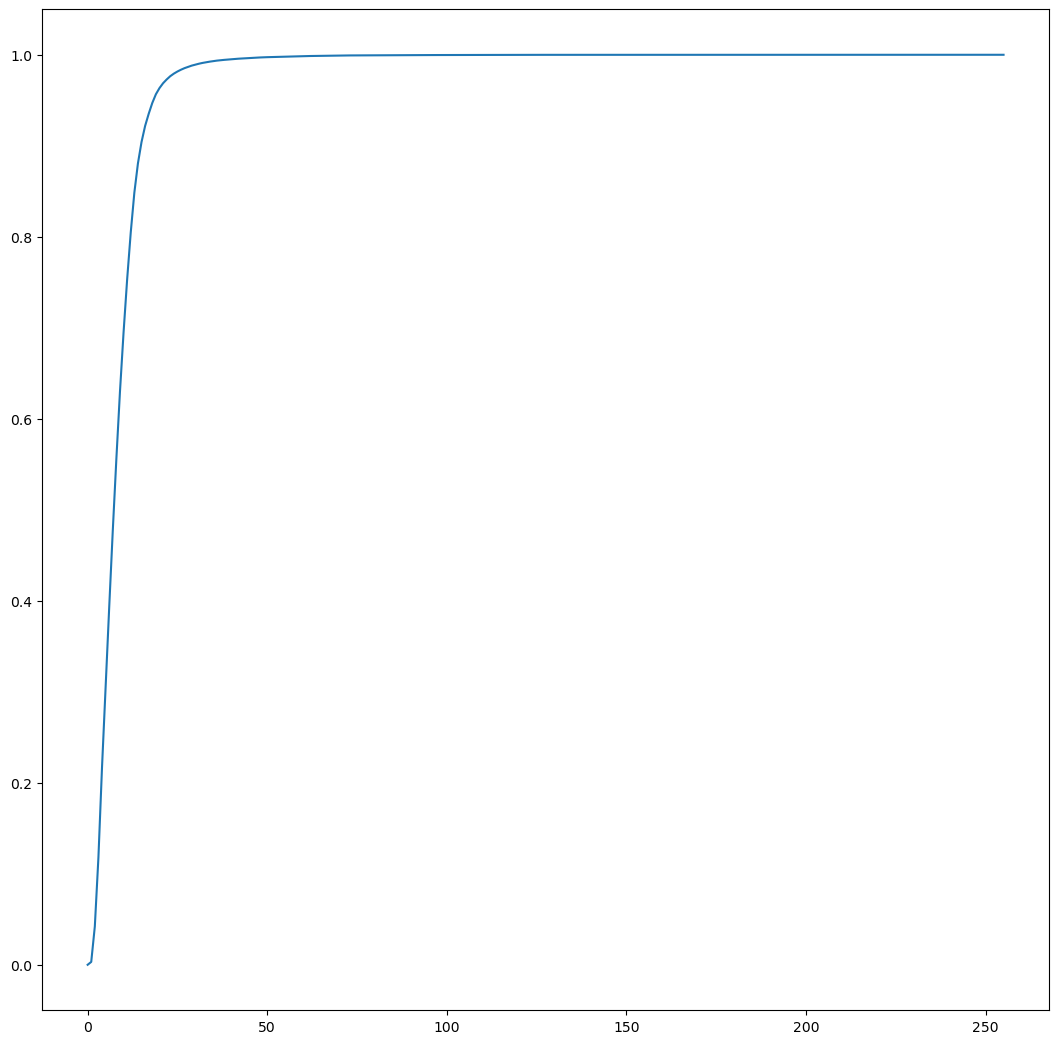

In [37]:
total_num_pixels = cum_hist_B.max()  # or c[-1]
assert cum_hist_B.max() == cum_hist_B[-1]

cdf_norm = cum_hist_B / total_num_pixels
plt.plot(cdf_norm)

In [38]:
L = 256
y_prime = cdf_norm * (L - 1)
y_prime

array([2.26666667e-02, 8.30875000e-01, 1.07645417e+01, 3.00758333e+01,
       5.53201250e+01, 7.77098333e+01, 1.00120083e+02, 1.21705833e+02,
       1.41831000e+02, 1.60618125e+02, 1.77189583e+02, 1.92101417e+02,
       2.05203458e+02, 2.16322875e+02, 2.24554417e+02, 2.30549750e+02,
       2.35056875e+02, 2.38467500e+02, 2.41502708e+02, 2.43940792e+02,
       2.45667000e+02, 2.47027708e+02, 2.48078875e+02, 2.48999708e+02,
       2.49718667e+02, 2.50312958e+02, 2.50821542e+02, 2.51262833e+02,
       2.51623375e+02, 2.51969750e+02, 2.52235375e+02, 2.52500292e+02,
       2.52719875e+02, 2.52904042e+02, 2.53076167e+02, 2.53228458e+02,
       2.53364458e+02, 2.53475667e+02, 2.53572000e+02, 2.53659833e+02,
       2.53754042e+02, 2.53831250e+02, 2.53903500e+02, 2.53965833e+02,
       2.54029583e+02, 2.54086250e+02, 2.54142917e+02, 2.54197458e+02,
       2.54248458e+02, 2.54300167e+02, 2.54327083e+02, 2.54356125e+02,
       2.54390833e+02, 2.54421292e+02, 2.54451750e+02, 2.54492125e+02,
      

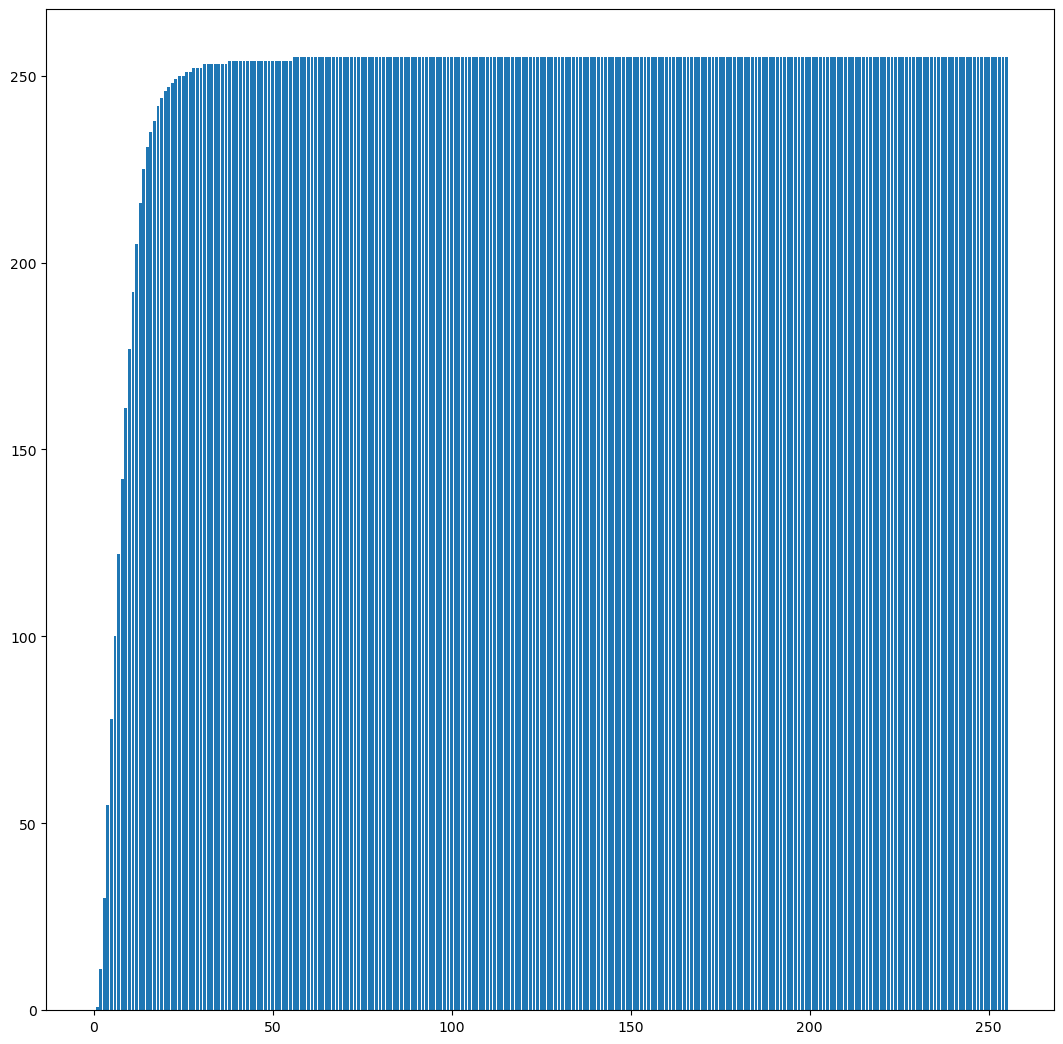

In [39]:
y = np.round(y_prime, decimals=0)

# y is our equalization function
# note that maximum value is 255 and all values are integers
# plot with bar to indicate that the values are discrete
plt.bar(range(len(y)), y);

In [40]:
assert 0 <= y.min()
assert y.max() <= 255

In [41]:
len(y)

256

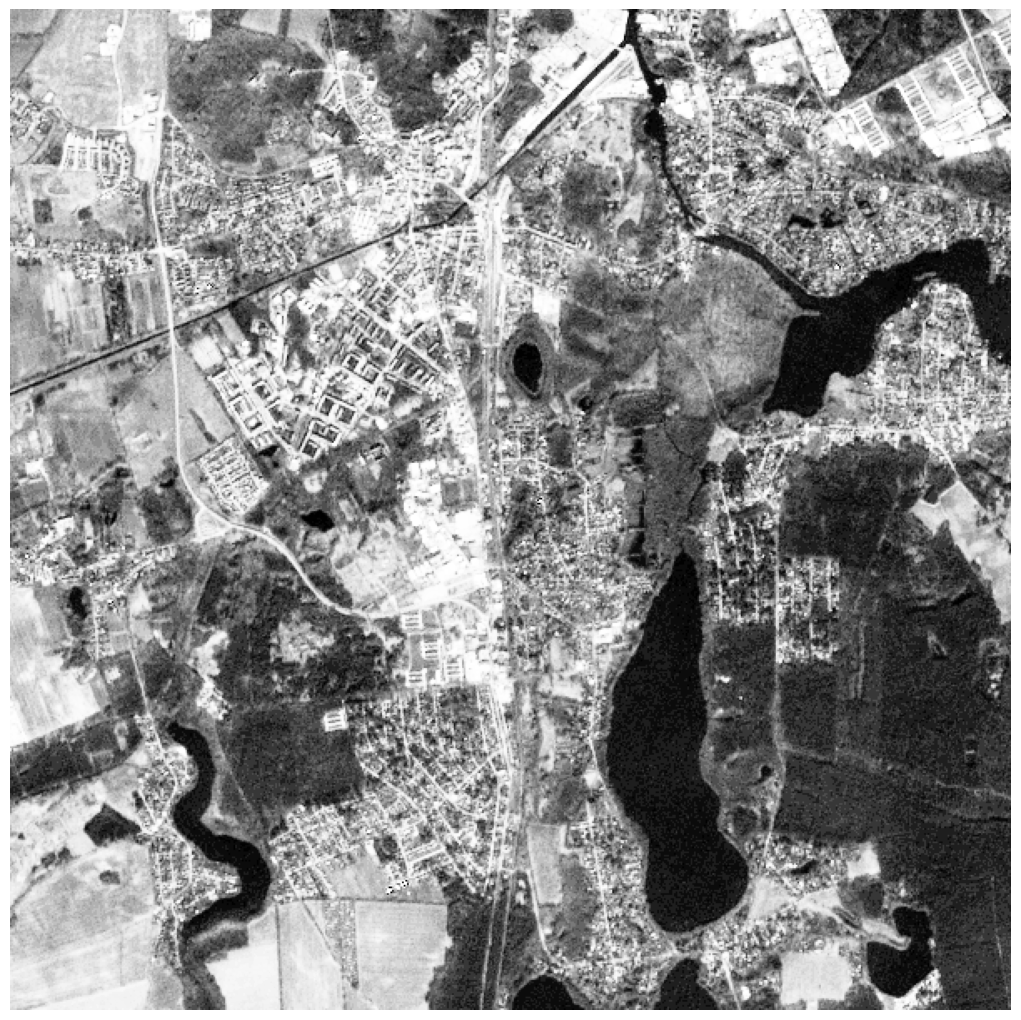

In [45]:
img_B_eq = y[img_B]
img_B_eq = np.uint8(img_B_eq)

imshow(img_B_eq, vmin=0, vmax=255, cmap="gray");

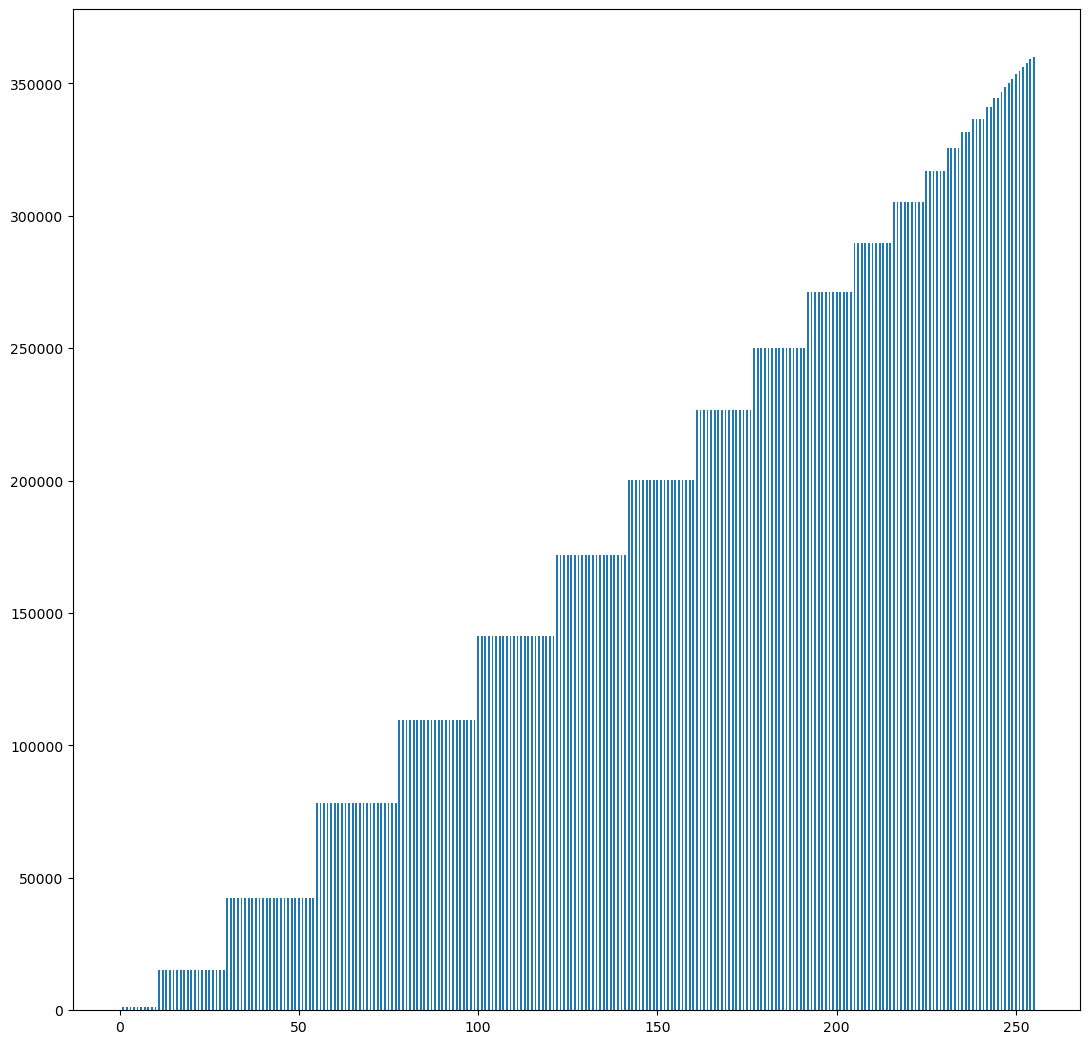

In [46]:
hist_B_eq, _ = np.histogram(img_B_eq, 256)
c = hist_B_eq.cumsum()
plt.bar(range(len(c)), c, width=0.5);

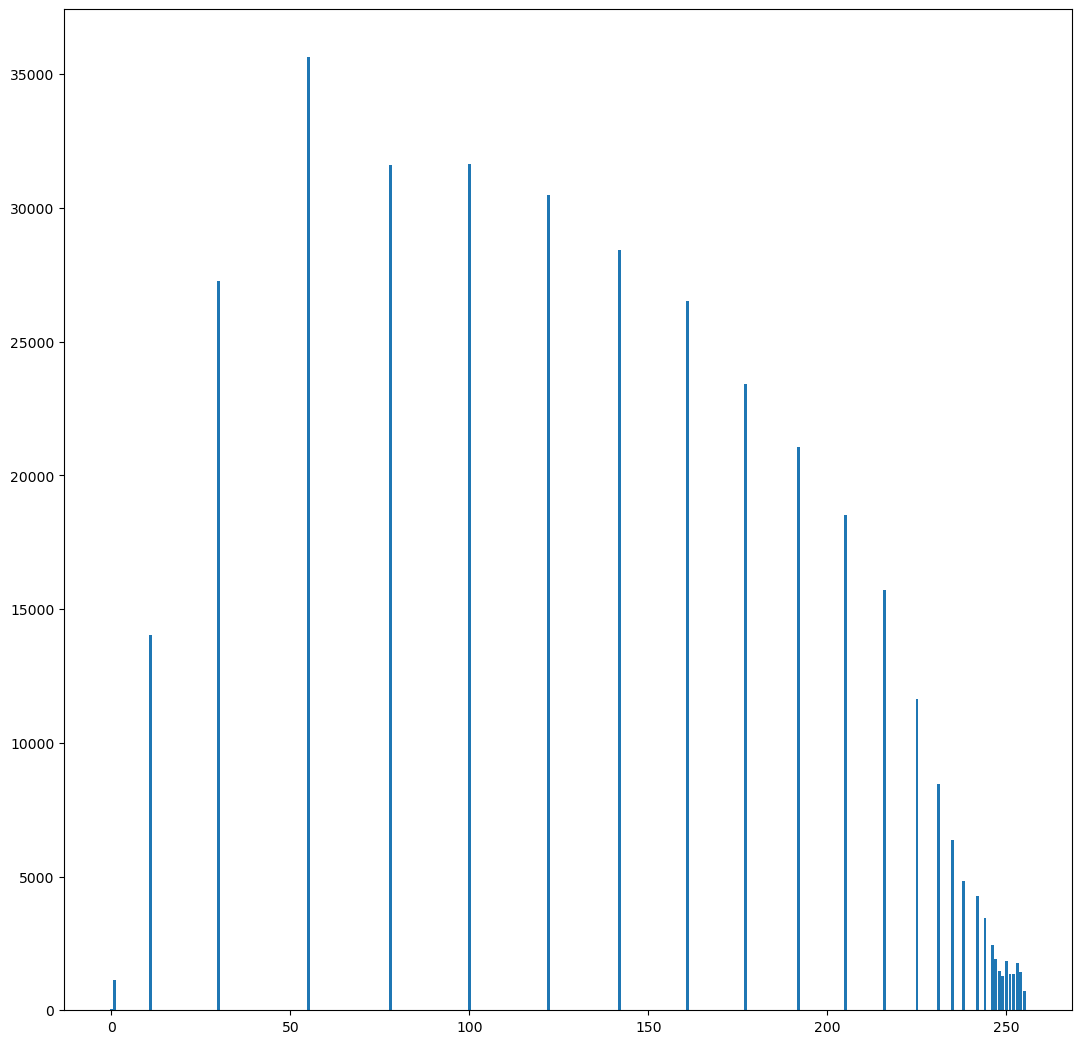

In [47]:
plt.bar(range(len(hist_B_eq)), hist_B_eq);

## Image Thresholding

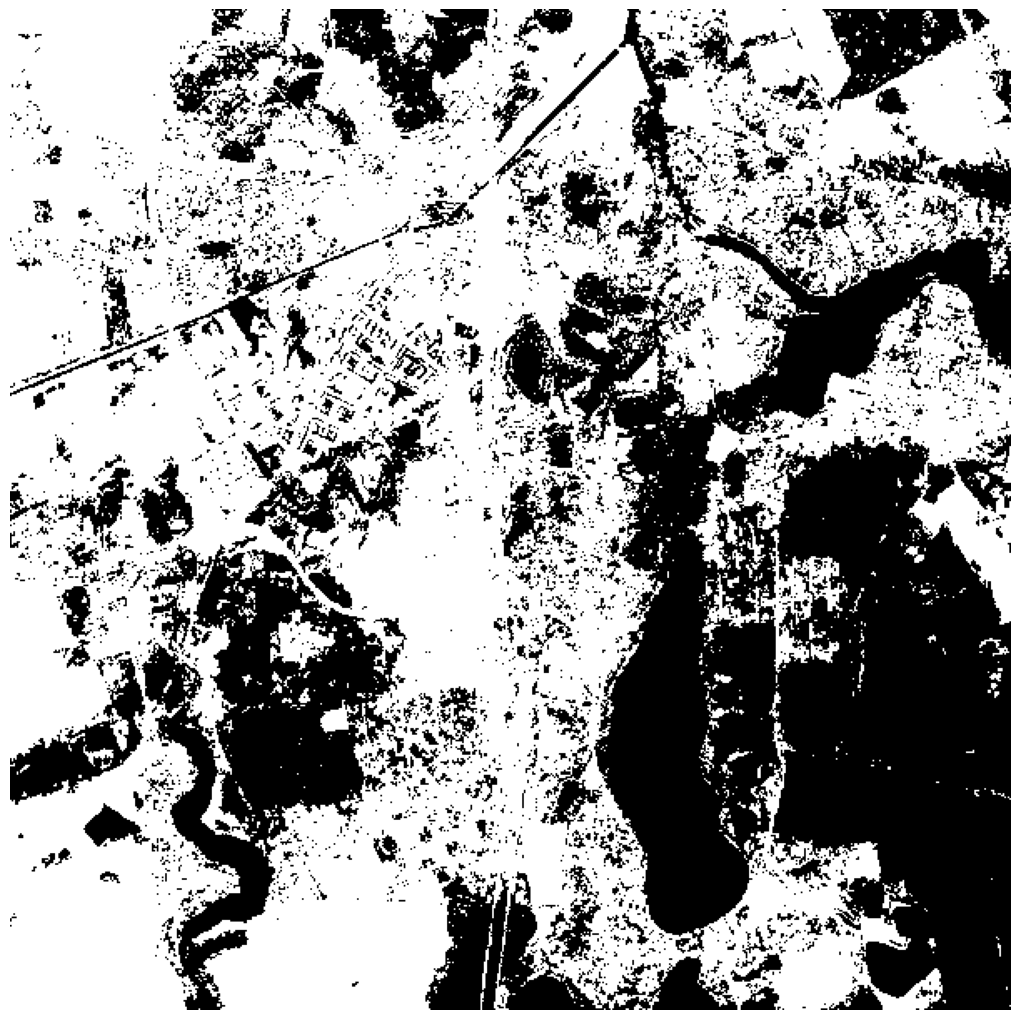

In [48]:
threshold = 120
img_B_eq_thres = np.where(img_B_eq < threshold, 0, 255)

imshow(img_B_eq_thres, cmap="gray", vmin=0, vmax=255)

### In-course practice:
Create a mask from the thresholded image and apply it on the original image and the contrast-adjusted image. 
The final image `img_masked` should be black in the masked out pixels and other pixels representing with their original values (colors).
So values below the previous threshold should become 0 and the values equal/larger than the threshold should stay the same.

In [49]:
s = f"""
{img_B_eq_thres.shape=}
{img.shape=}
"""
print(s)


img_B_eq_thres.shape=(600, 600)
img.shape=(600, 600, 3)

